![](./images/resort2.jpg)

In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

# 1. Import CSV:s for HIMOS, KOLI, LEVI, MESSILÄ, PEURAMAA, RUKA, SAARISELKÄ, TAHKO, VUOKATTI👍

In [173]:
# HIMOS
himos_df = pd.read_csv("C:\\Code\\Miniproject 2\\combined data\\himos.csv", parse_dates=['Date'])

# KOLI
koli_df = pd.read_csv("C:\\Code\\Miniproject 2\\combined data\\koli.csv", parse_dates=['Date'])

# LEVI
levi_df = pd.read_csv("C:\\Code\\Miniproject 2\\combined data\\levi.csv", parse_dates=['Date'])

# MESSILA
messila_df = pd.read_csv("C:\\Code\\Miniproject 2\\combined data\\messila.csv", parse_dates=['Date'])

# PEURAMAA
peuramaa_df = pd.read_csv("C:\\Code\\Miniproject 2\\combined data\\peuramaa.csv", parse_dates=['Date'])

# PYHA
pyha_df = pd.read_csv("C:\\Code\\Miniproject 2\\combined data\\pyha.csv", parse_dates=['Date'])

# RUKA
ruka_df = pd.read_csv("C:\\Code\\Miniproject 2\\combined data\\ruka.csv", parse_dates=['Date'])

# SAARISELKA
saariselka_df = pd.read_csv("C:\\Code\\Miniproject 2\\combined data\\saariselka.csv", parse_dates=['Date'])

# TAHKO
tahko_df = pd.read_csv("C:\\Code\\Miniproject 2\\combined data\\tahko.csv", parse_dates=['Date'])

# VUOKATTI
vuokatti_df = pd.read_csv("C:\\Code\\Miniproject 2\\combined data\\vuokatti.csv", parse_dates=['Date'])

In [174]:
dataframes = [himos_df,koli_df,levi_df,messila_df,peuramaa_df,pyha_df,ruka_df,saariselka_df,tahko_df, vuokatti_df]
 
for dataframe in dataframes:
    filt = dataframe['Snow depth [cm]'] == -1
    dataframe.loc[filt, 'Snow depth [cm]'] = 0 

## 1.1 Combine Saariselkä, Pyhä, Himos and Peuramaa to model training set

In [175]:
training_df = pd.concat([saariselka_df, pyha_df, himos_df, peuramaa_df])
training_df.head(1)

,Cloud cover [1/8],Date,Snow depth [cm],Unnamed: 0,Average temperature [°C],latitude,longitude,Average radiation
0,Clear (0/8),2004-01-01,40,0.0,-21.8,68.425135,27.449662,63.4


## 1.2 Combine Levi, Ruka, Koli, Tahko and Messilä into future prediction set

In [176]:
prediction_df = pd.concat([levi_df, ruka_df, koli_df, tahko_df, messila_df])
prediction_df.head(1)

,Cloud cover [1/8],Date,Snow depth [cm],Unnamed: 0,Average temperature [°C],latitude,longitude,Average radiation
0,Clear (0/8),2004-01-01,39,0.0,-27.3,67.785461,24.856284,63.4


## 1.3 Vuokatti will be our testing data set

In [177]:
test_df = vuokatti_df
test_df.head(1)

,Cloud cover [1/8],Date,Snow depth [cm],Unnamed: 0,Average temperature [°C],latitude,longitude,Average radiation
0,Clear (0/8),2004-01-01,31,0.0,-24.9,64.139453,28.287481,63.4


# 2. Sort datasets by date to chronological order for model📈

In [178]:
# We need future prediction sets separately, because later we generate future data for Independent variables which is needed for the model
dataframes = [levi_df, ruka_df, koli_df, tahko_df, messila_df, test_df, prediction_df, training_df]
for dataframe in dataframes:
    dataframe.sort_values(by='Date', inplace=True)

# 3. Remove duplicate rows👯

In [179]:
# One set doesn't have the unnamed column
for dataframe in dataframes:
    print(dataframe.shape)


(7306, 8)
(7306, 7)
(7306, 8)
(7306, 8)
(7307, 8)
(7306, 8)
(36531, 8)
(29224, 8)


In [180]:
for dataframe in dataframes:
    dataframe.drop_duplicates(inplace=True, ignore_index=True)

In [181]:
# One set doesn't have the unnamed column
for dataframe in dataframes:
    print(dataframe.shape)

(7306, 8)
(7306, 7)
(7306, 8)
(7306, 8)
(7307, 8)
(7306, 8)
(36531, 8)
(29224, 8)


# 4. Clean the data in suitable format🧹

## 4.1 Clean up cloud data that there is only numbers left🌨️

In [182]:
for dataframe in dataframes:
    dataframe['Cloud cover [1/8]'] = dataframe['Cloud cover [1/8]'].str.extract(r'\((\d+)/')

## 4.2 Drop unnamed column👽

In [183]:
for dataframe in dataframes:
    if 'Unnamed: 0' in dataframe:
        dataframe.drop('Unnamed: 0',axis=1, inplace=True)

## 4.3 Convert string columns to new float columns🧮

In [184]:
# Check columns before conversion
for dataframe in dataframes:
    print(dataframe.dtypes)

Cloud cover [1/8]                   object
Date                        datetime64[ns]
Snow depth [cm]                     object
Average temperature [°C]            object
latitude                           float64
longitude                          float64
Average radiation                  float64
dtype: object
Cloud cover [1/8]                   object
Date                        datetime64[ns]
Snow depth [cm]                     object
Average temperature [°C]            object
latitude                           float64
longitude                          float64
Average radiation                  float64
dtype: object
Cloud cover [1/8]                   object
Date                        datetime64[ns]
Snow depth [cm]                     object
Average temperature [°C]            object
latitude                           float64
longitude                          float64
Average radiation                  float64
dtype: object
Cloud cover [1/8]                   object
Date        

In [185]:
# Overwrite old columns changed 14.3.2024
for dataframe in dataframes:
    dataframe['Date_float'] = np.array(dataframe['Date'].dropna().index.values, dtype=float)
    dataframe['Average temperature [°C]'] = pd.to_numeric(dataframe['Average temperature [°C]'], errors='coerce')
    dataframe['Snow depth [cm]'] = pd.to_numeric(dataframe['Snow depth [cm]'], errors='coerce')
    dataframe['Cloud cover [1/8]'] = pd.to_numeric(dataframe['Cloud cover [1/8]'], errors='coerce')

In [186]:
# Check new columns
for dataframe in dataframes:
    print(dataframe.dtypes)

Cloud cover [1/8]                  float64
Date                        datetime64[ns]
Snow depth [cm]                    float64
Average temperature [°C]           float64
latitude                           float64
longitude                          float64
Average radiation                  float64
Date_float                         float64
dtype: object
Cloud cover [1/8]                  float64
Date                        datetime64[ns]
Snow depth [cm]                    float64
Average temperature [°C]           float64
latitude                           float64
longitude                          float64
Average radiation                  float64
Date_float                         float64
dtype: object
Cloud cover [1/8]                  float64
Date                        datetime64[ns]
Snow depth [cm]                    float64
Average temperature [°C]           float64
latitude                           float64
longitude                          float64
Average radiation         

## 4.4 Filling missing values🍼

In [187]:
# Print missing values
for dataframe in dataframes:
    print(dataframe.isna().sum())

Cloud cover [1/8]           92
Date                         0
Snow depth [cm]             28
Average temperature [°C]    62
latitude                     0
longitude                    0
Average radiation            0
Date_float                   0
dtype: int64
Cloud cover [1/8]           67
Date                         0
Snow depth [cm]             28
Average temperature [°C]    75
latitude                     0
longitude                    0
Average radiation            0
Date_float                   0
dtype: int64
Cloud cover [1/8]           193
Date                          0
Snow depth [cm]               1
Average temperature [°C]     15
latitude                      0
longitude                     0
Average radiation             0
Date_float                    0
dtype: int64
Cloud cover [1/8]           103
Date                          0
Snow depth [cm]               0
Average temperature [°C]     18
latitude                      0
longitude                     0
Average radiation

In [188]:
# Function for filling missing values in dataframe
def fill_na(dataframe, column):
    #fillna_list = np.array(['Cloud cover [1/8]', 'Snow depth_float', 'Temp_float'])
    filled_forward = dataframe[column].fillna(method='ffill')
 
    # # Backward fill NaN values in column 'A'
    filled_backward = dataframe[column].fillna(method='bfill')
    
    # # Handle first and last value separately
    first_value = dataframe[column].iloc[0]
    last_value = dataframe[column].iloc[-1]
    
    # # Calculate the average of forward filled and backward filled values
    average_values = (filled_forward + filled_backward) / 2
    
    # # Replace NaN values in column 'A' with the calculated average
    dataframe[column] = dataframe[column].combine_first(average_values)
    
    # # Handle first and last value
    if pd.isna(first_value):
        dataframe[column].iloc[0] = filled_backward.iloc[0]
    if pd.isna(last_value):
        dataframe[column].iloc[-1] = filled_forward.iloc[-1]

for dataframe in dataframes:
    fill_na(dataframe, 'Cloud cover [1/8]')
    fill_na(dataframe, 'Snow depth [cm]')
    fill_na(dataframe, 'Average temperature [°C]')

C:\Users\Jussi\AppData\Local\Temp\ipykernel_16976\4025917871.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filled_forward = dataframe[column].fillna(method='ffill')
C:\Users\Jussi\AppData\Local\Temp\ipykernel_16976\4025917871.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filled_backward = dataframe[column].fillna(method='bfill')
C:\Users\Jussi\AppData\Local\Temp\ipykernel_16976\4025917871.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filled_forward = dataframe[column].fillna(method='ffill')
C:\Users\Jussi\AppData\Local\Temp\ipykernel_16976\4025917871.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filled_backward =

In [189]:
# Print missing values
for dataframe in dataframes:
    print(dataframe.isna().sum())

Cloud cover [1/8]           0
Date                        0
Snow depth [cm]             0
Average temperature [°C]    0
latitude                    0
longitude                   0
Average radiation           0
Date_float                  0
dtype: int64
Cloud cover [1/8]           0
Date                        0
Snow depth [cm]             0
Average temperature [°C]    0
latitude                    0
longitude                   0
Average radiation           0
Date_float                  0
dtype: int64
Cloud cover [1/8]           0
Date                        0
Snow depth [cm]             0
Average temperature [°C]    0
latitude                    0
longitude                   0
Average radiation           0
Date_float                  0
dtype: int64
Cloud cover [1/8]           0
Date                        0
Snow depth [cm]             0
Average temperature [°C]    0
latitude                    0
longitude                   0
Average radiation           0
Date_float                  0
d

## 4.5 Making the future data🔮

### 4.5.1 Calculating daily changes (for future prediction venue sets) for clouds🌨️, temperature🌡️ and radiation🌞

In [190]:
def daily_changes (dataframe):    
    first_year = (dataframe['Date'].dt.year == 2004)
    last_year = (dataframe['Date'].dt.year == 2023)
    # whole_data_df[last_year].iloc[:,[0,6,8]].mean()
    daily_cloud_cover_change, daily_temperature_change, daily_radiation_change = (dataframe[last_year].iloc[:,[0,3,6]].mean() - dataframe[first_year].iloc[:,[0,3,6]].mean()) / 7304
    return daily_cloud_cover_change, daily_radiation_change, daily_temperature_change

daily_changes_levi = daily_changes(levi_df)
daily_changes_ruka = daily_changes(ruka_df)
daily_changes_koli = daily_changes(koli_df)
daily_changes_tahko = daily_changes(tahko_df)
daily_changes_messila = daily_changes(messila_df)

daily_changes_ruka

(-3.0288251796562135e-05, 0.0012807070704065572, 7.472410516655774e-05)

### 4.5.2 Filling the future data⛽

In [191]:
def fill_the_future(df, changes_tuple, years=50):
 
    prediction_data = pd.DataFrame()
    # Take the last year (2023) from df and make it new df
    last_year = df[df['Date'].dt.year == 2023]
    # Columns we want to fill
    last_year = last_year[["Date","Average temperature [°C]", "Average radiation", "Cloud cover [1/8]","latitude", "longitude"]]
 
    num_years = years
    # Iterate over each year
    for i in range(1, num_years + 1):
 
        # Adjust temperature for each year
        temperature_adjustment = changes_tuple[2] * i  # Increase by 0.5 Celsius for each subsequent year
        radiation_adjustment = changes_tuple[1] * i
        cloud_adjustment = changes_tuple[0] * i
        # Create additional data for the current year with adjusted temperature
        new_date = last_year['Date'] + pd.DateOffset(years=i)
        new_temp = last_year["Average temperature [°C]"].astype(float) + temperature_adjustment
        new_rad = last_year["Average radiation"].astype(float) + radiation_adjustment
        new_cloud = last_year["Cloud cover [1/8]"].astype(float) + cloud_adjustment
        new_latitude = last_year["latitude"].astype(float)
        new_longitude = last_year["longitude"].astype(float)
 
        date_df = pd.DataFrame(new_date)
        temp_df = pd.DataFrame(new_temp)
        rad_df = pd.DataFrame(new_rad)
        cloud_df = pd.DataFrame(new_cloud)
        latitude_df = pd.DataFrame(new_latitude)
        longitude_df = pd.DataFrame(new_longitude)
 
        result = pd.merge(date_df, temp_df, left_index=True, right_index=True)
        result = pd.merge(result, rad_df, left_index=True, right_index=True)
        result = pd.merge(result, cloud_df, left_index=True, right_index=True)
        result = pd.merge(result, latitude_df, left_index=True, right_index=True)
        result = pd.merge(result, longitude_df, left_index=True, right_index=True)
 
        prediction_data = pd.concat([prediction_data, result], ignore_index=True)
 
    # longi = df['longitude'][0]
    # lati = df['latitude'][0]
    # prediction_data['latitude'] = longi
    # prediction_data['longitude'] = lati
   
    return prediction_data

# def fill_the_future(df, changes_tuple, years=50):

#     prediction_data = pd.DataFrame()
#     # Take the last year (2023) from df and make it new df
#     last_year = df[df['Date'].dt.year == 2023]
#     # Columns we want to fill
#     last_year = last_year[["Date","Average temperature [°C]", "Average radiation", "Cloud cover [1/8]", "latitude", "longitude"]]

#     num_years = years
#     # Iterate over each year
#     for i in range(1, num_years + 1):

#         # Adjust temperature for each year
#         temperature_adjustment = changes_tuple[2] * i  # Increase by 0.5 Celsius for each subsequent year
#         radiation_adjustment = changes_tuple[1] * i
#         cloud_adjustment = changes_tuple[0] * i
#         # Create additional data for the current year with adjusted temperature
#         new_date = last_year['Date'] + pd.DateOffset(years=i)
#         new_temp = last_year["Average temperature [°C]"].astype(float) + temperature_adjustment
#         new_rad = last_year["Average radiation"].astype(float) + radiation_adjustment
#         new_cloud = last_year["Cloud cover [1/8]"].astype(float) + cloud_adjustment
#         new_longitude = df['longitude'][0]
#         new_latitude = df['latitude'][0]

#         date_df = pd.DataFrame(new_date)
#         temp_df = pd.DataFrame(new_temp)
#         rad_df = pd.DataFrame(new_rad)
#         cloud_df = pd.DataFrame(new_cloud)
#         longitude_df = pd.DataFrame(new_longitude)
#         latitude_df = pd.DataFrame(new_latitude)

#         result = pd.merge(date_df, temp_df, left_index=True, right_index=True)
#         result = pd.merge(result, rad_df, left_index=True, right_index=True)
#         result = pd.merge(result, cloud_df, left_index=True, right_index=True)
#         result = pd.merge(result, latitude_df, left_index=True, right_index=True)
#         result = pd.merge(result, longitude_df, left_index=True, right_index=True)
       
#         prediction_data = pd.concat([prediction_data, result], ignore_index=True)

#     # longi = df['longitude'][0]
#     # lati = df['latitude'][0]
#     # prediction_data['latitude'] = longi
#     # prediction_data['longitude'] = lati

#     return prediction_data

In [192]:
future_levi = levi_df.copy()
future_ruka = ruka_df.copy()
future_koli = koli_df.copy()
future_tahko = tahko_df.copy()
future_messila = messila_df.copy()

future_dataframes = [future_levi, future_ruka, future_koli, future_tahko, future_messila]
# How many years ahead we want to predict data
years_to_fill = 50
future_levi = fill_the_future(future_levi, daily_changes_levi, years_to_fill)
future_ruka = fill_the_future(future_ruka, daily_changes_ruka, years_to_fill)
future_koli = fill_the_future(future_koli, daily_changes_koli, years_to_fill)
future_tahko = fill_the_future(future_tahko, daily_changes_tahko, years_to_fill)
future_messila = fill_the_future(future_messila, daily_changes_messila, years_to_fill)


In [193]:
future_levi

,Date,Average temperature [°C],Average radiation,Cloud cover [1/8],latitude,longitude
0,2024-01-01,-2.900019,34.201281,7.999950,67.785461,24.856284
1,2024-01-02,-13.200019,7.916180,6.999950,67.785461,24.856284
2,2024-01-03,-15.400019,6.693705,7.999950,67.785461,24.856284
3,2024-01-04,-10.400019,5.236382,-0.000050,67.785461,24.856284
4,2024-01-05,-7.300019,7.470978,7.999950,67.785461,24.856284
...,...,...,...,...,...,...
18245,2073-12-27,-11.100929,8.534988,7.997515,67.785461,24.856284
18246,2073-12-28,-19.900929,6.995204,7.997515,67.785461,24.856284
18247,2073-12-29,-12.700929,3.685623,7.997515,67.785461,24.856284
18248,2073-12-30,-19.900929,0.808480,6.997515,67.785461,24.856284


# 5. Machine Learning🦾

## 5.1 Datasets have been split into 
    4 venue sets combined for training
    1 set for testing
    5 venue sets combined for predictions in future data points

## 5.2 Models🤖

## Use Cloud cover, latitude, radiation, date, temp as Independent Variables (Features)
## Use Snow depth as Dependent Variables (Target Variable):

In [194]:
training_df.tail(1)

,Cloud cover [1/8],Date,Snow depth [cm],Average temperature [°C],latitude,longitude,Average radiation,Date_float
29223,0.0,2024-01-01,27.0,-15.8,60.102686,24.464341,7.247213,29223.0


### 5.2.1 Training split

In [195]:
# Make Independent variables and target variable for combined trained set
X_train = training_df.iloc[:,[0,3,4,6]]
y_train = training_df.iloc[:,[2]]

In [196]:
y_train.head()

,Snow depth [cm]
0,40.0
1,27.5
2,15.0
3,25.0
4,0.0


In [197]:
X_train.head()

,Cloud cover [1/8],Average temperature [°C],latitude,Average radiation
0,0.0,-21.8,68.425135,63.400000
1,7.0,-7.2,60.102686,63.400000
2,8.0,-17.2,61.879612,63.400000
3,8.0,-29.6,67.014257,63.400000
4,0.0,-11.9,60.102686,65.666667


### 5.2.2 Testing split

In [198]:
# Choose columns from combined test dataset for testing
X_test = test_df.iloc[:,[0,3,4,6]]
y_test = test_df.iloc[:,[2]]

In [199]:
y_test.head()

,Snow depth [cm]
0,31.0
1,31.0
2,31.0
3,32.0
4,32.0


In [200]:
X_test.head()

,Cloud cover [1/8],Average temperature [°C],latitude,Average radiation
0,0.0,-24.9,64.139453,63.400000
1,1.0,-19.2,64.139453,65.666667
2,8.0,-13.0,64.139453,54.566667
3,8.0,-13.9,64.139453,4.500000
4,8.0,-13.5,64.139453,3.466667


### 5.3.3 First degree Linear Regression📏

In [201]:
# First degree regression model
model = LinearRegression()
model.get_params()

model.fit(X_train, y_train)
y_predicted_train = model.predict(X_train)
y_predicted_test1d = model.predict(X_test)

# Evaluating the model
train_rmse = np.sqrt(mean_squared_error(y_train, y_predicted_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_predicted_test1d))

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
r_squared = r2_score(y_test, y_predicted_test1d)
print("R-squared:", r_squared)

Train RMSE: 18.32488621773346
Test RMSE: 16.36957202211636
R-squared: 0.4301862866348012


### 5.3.4 Second degree Linear Regression

In [202]:
# Second degree regression model
poly = PolynomialFeatures(degree=2, include_bias=False)

model_2d = LinearRegression()

# Transform to 2D array
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
model_2d.fit(X_train_poly, y_train)

y_predicted_train = model_2d.predict(X_train_poly)
y_predicted_test2d = model_2d.predict(X_test_poly)

# Evaluating the model
train_rmse = np.sqrt(mean_squared_error(y_train, y_predicted_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_predicted_test2d))

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
r_squared = r2_score(y_test, y_predicted_test2d)
print("R-squared:", r_squared)

Train RMSE: 17.361639070356908
Test RMSE: 16.149311020973297
R-squared: 0.4454173938683673


### 5.3.5 Third degree Linear Regression

Current best model

In [203]:
future_levi.head(1)

,Date,Average temperature [°C],Average radiation,Cloud cover [1/8],latitude,longitude
0,2024-01-01,-2.900019,34.201281,7.99995,67.785461,24.856284


In [252]:
# Third degree regression model


poly = PolynomialFeatures(degree=3, include_bias=False)

model_3d = LinearRegression()

# Transform to 3D array
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
model_3d.fit(X_train_poly, y_train)

y_predicted_train3d = model_3d.predict(X_train_poly)
y_predicted_test3d = model_3d.predict(X_test_poly)

# Evaluating the model
train_rmse = np.sqrt(mean_squared_error(y_train, y_predicted_train3d))
test_rmse = np.sqrt(mean_squared_error(y_test, y_predicted_test3d))

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
r_squared = r2_score(y_test, y_predicted_test3d)
print("R-squared:", r_squared)


y_predicted_test3d

Train RMSE: 16.19274966449462
Test RMSE: 15.045354215727963
R-squared: 0.5186476675492193


array([[32.13026627],
       [39.20789627],
       [40.83961584],
       ...,
       [22.75402569],
       [23.16365214],
       [11.84974297]])

In [205]:
future_levi

,Date,Average temperature [°C],Average radiation,Cloud cover [1/8],latitude,longitude
0,2024-01-01,-2.900019,34.201281,7.999950,67.785461,24.856284
1,2024-01-02,-13.200019,7.916180,6.999950,67.785461,24.856284
2,2024-01-03,-15.400019,6.693705,7.999950,67.785461,24.856284
3,2024-01-04,-10.400019,5.236382,-0.000050,67.785461,24.856284
4,2024-01-05,-7.300019,7.470978,7.999950,67.785461,24.856284
...,...,...,...,...,...,...
18245,2073-12-27,-11.100929,8.534988,7.997515,67.785461,24.856284
18246,2073-12-28,-19.900929,6.995204,7.997515,67.785461,24.856284
18247,2073-12-29,-12.700929,3.685623,7.997515,67.785461,24.856284
18248,2073-12-30,-19.900929,0.808480,6.997515,67.785461,24.856284


<Axes: >

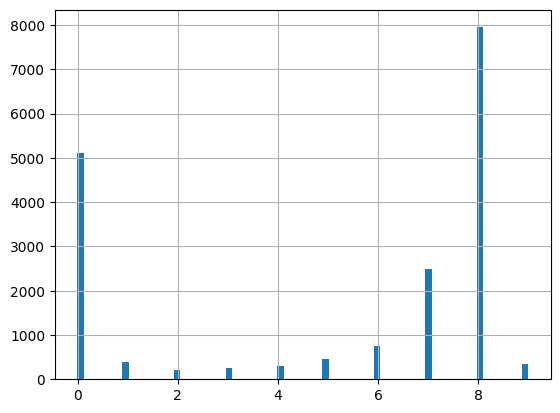

In [206]:
future_levi['Cloud cover [1/8]'].hist(bins=70)

In [207]:
future_levi['latitude'] = future_levi['latitude'][0]

In [257]:
#Cloud cover [1/8]	Average temperature [°C]	latitude	Average radiation
future_levi_X = future_levi[['Cloud cover [1/8]', 'Average temperature [°C]', 'latitude', 'Average radiation']]
future_ruka_X = future_ruka[['Cloud cover [1/8]', 'Average temperature [°C]', 'latitude', 'Average radiation']]
future_koli_X = future_koli[['Cloud cover [1/8]', 'Average temperature [°C]', 'latitude', 'Average radiation']]
future_tahko_X = future_tahko[['Cloud cover [1/8]', 'Average temperature [°C]', 'latitude', 'Average radiation']]
future_messila_X = future_messila[['Cloud cover [1/8]', 'Average temperature [°C]', 'latitude', 'Average radiation']]
# Transform to 3D array
# X_poly_levi = poly.fit_transform(future_levi_X)
# y_predicted_future_levi = model_3d.predict(X_poly_levi)
# y_predicted_future_levi

In [211]:

future_levi_y = model.predict(future_levi_X)
future_levi_y

array([[26.99025682],
       [43.00490454],
       [46.80340662],
       ...,
       [42.15710298],
       [53.9397014 ],
       [48.50515333]])

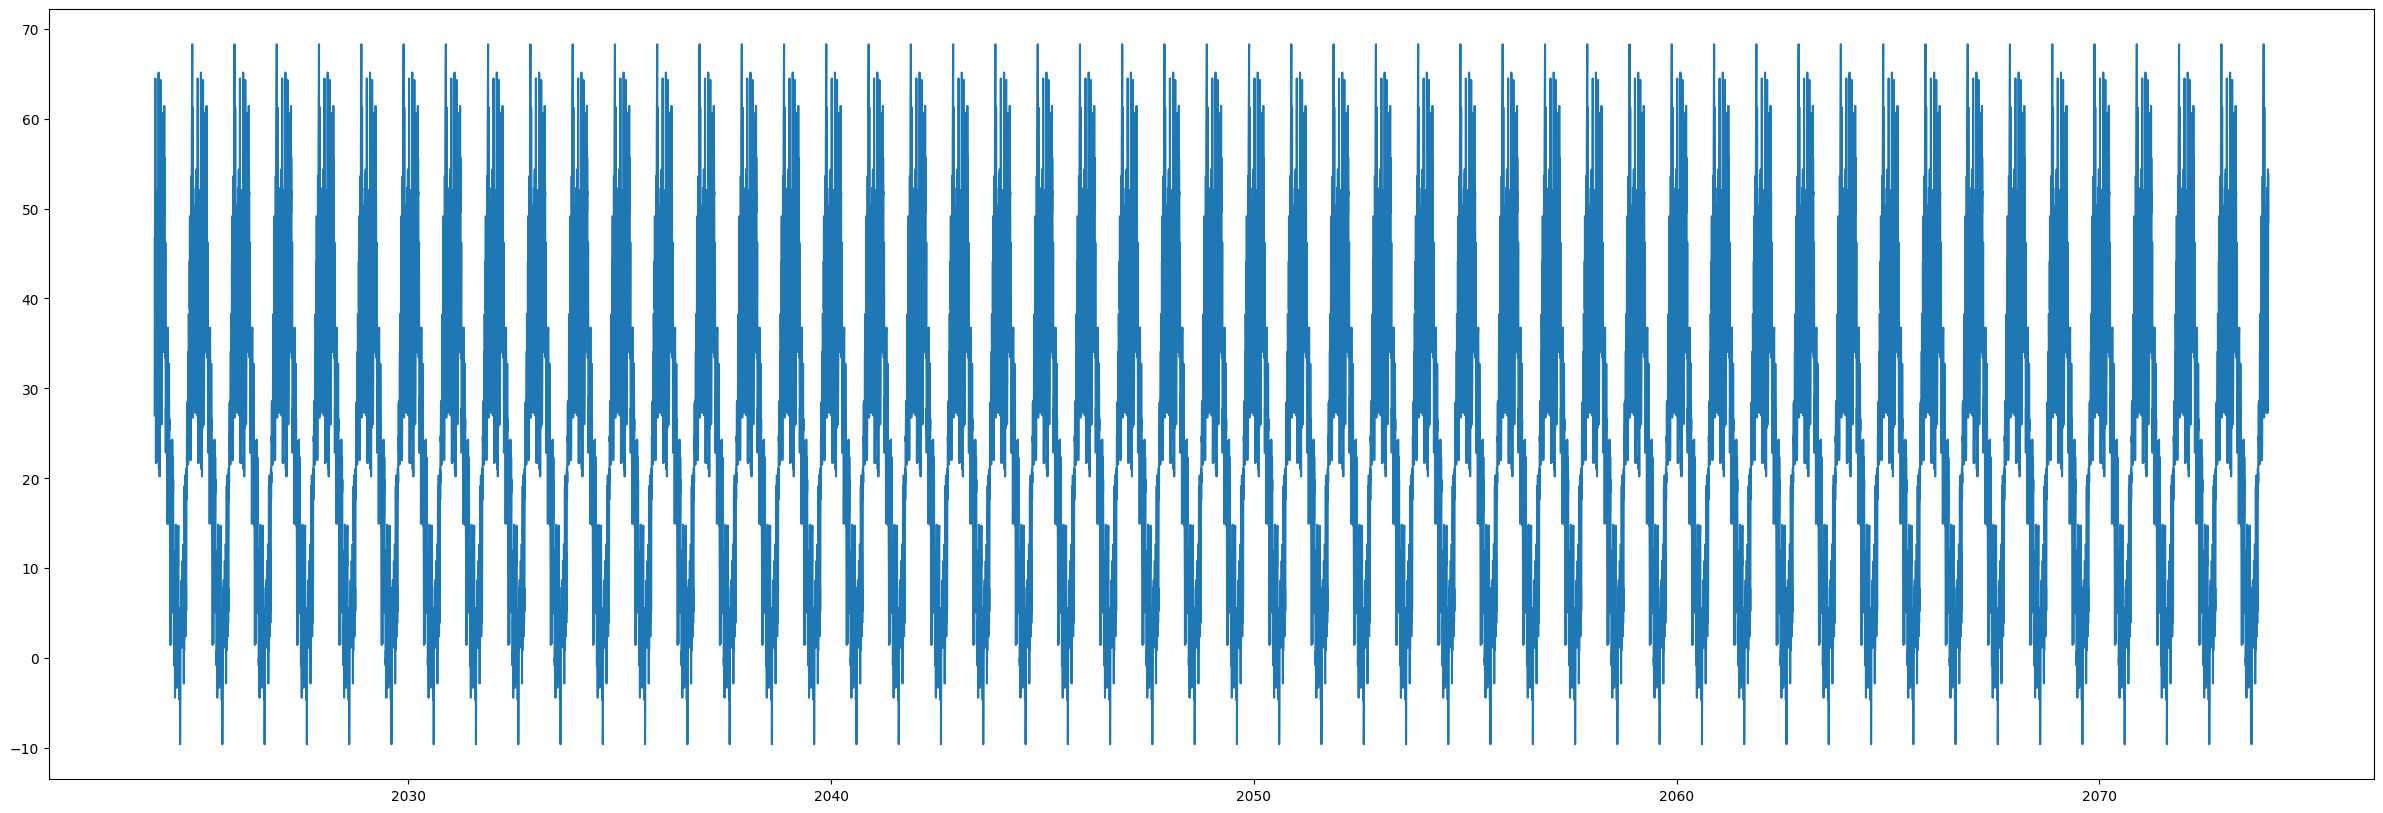

In [212]:
fig, ax = plt.subplots(figsize=(30,10))

ax.plot(future_levi['Date'], future_levi_y)
plt.show()

### 5.3.6 Fourth degree Linear Regression

In [213]:
# 4th degree regression model


poly = PolynomialFeatures(degree=4, include_bias=False)

model_4d = LinearRegression()

# Transform to 4D array
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
model_4d.fit(X_train_poly, y_train)

y_predicted_train4d = model_4d.predict(X_train_poly)
y_predicted_test4d = model_4d.predict(X_test_poly)

# Evaluating the model
train_rmse = np.sqrt(mean_squared_error(y_train, y_predicted_train4d))
test_rmse = np.sqrt(mean_squared_error(y_test, y_predicted_test4d))

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
r_squared = r2_score(y_test, y_predicted_test4d)
print("R-squared:", r_squared)

Train RMSE: 15.970679203682483
Test RMSE: 15.060840611334038
R-squared: 0.5176562320528642


### 5.3.7 Fifth degree Linear Regression

In [214]:
# 5th degree regression model

poly = PolynomialFeatures(degree=5, include_bias=False)

model_5d = LinearRegression()

# Transform to 5D array
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
model_5d.fit(X_train_poly, y_train)

y_predicted_train5d = model_5d.predict(X_train_poly)
y_predicted_test5d = model_5d.predict(X_test_poly)

# Evaluating the model
train_rmse = np.sqrt(mean_squared_error(y_train, y_predicted_train5d))
test_rmse = np.sqrt(mean_squared_error(y_test, y_predicted_test5d))

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
r_squared = r2_score(y_test, y_predicted_test5d)
print("R-squared:", r_squared)

Train RMSE: 15.638932055557254
Test RMSE: 14.694485520114602
R-squared: 0.5408368598013391


### 5.3.3 Sixth degree Linear Regression

In [215]:
# 6th degree regression model


poly = PolynomialFeatures(degree=6, include_bias=False)

model_6d = LinearRegression()

# Transform to 6D array
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
model_6d.fit(X_train_poly, y_train)

y_predicted_train6d = model_6d.predict(X_train_poly)
y_predicted_test6d = model_6d.predict(X_test_poly)

# Evaluating the model
train_rmse = np.sqrt(mean_squared_error(y_train, y_predicted_train6d))
test_rmse = np.sqrt(mean_squared_error(y_test, y_predicted_test6d))

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
r_squared = r2_score(y_test, y_predicted_test6d)
print("R-squared:", r_squared)

Train RMSE: 15.52282941061032
Test RMSE: 14.856182474553279
R-squared: 0.530676071816581


## 5.3 Test model accuracy🎯

# 6. Plotting

In [216]:
# fig, ax = plt.subplots(figsize=(30,10))
 
# %matplotlib inline
# ax.plot(test_df['Date'], y_test, marker='o', ls='', alpha=0.2, label='Actual snow depth')
# ax.plot(test_df['Date'], y_preds, marker='o', ls='', c='red', alpha=0.2, label='Predicted snow depth')
 
# ax.set(title='First model trained',xlabel='Date', ylabel='Snow depth (cm)')
# ax.legend()
# plt.show()

## 2nd degree model against real values

In [217]:
# Something wrong here!!

# fig, ax = plt.subplots(figsize=(30,10))
 
# %matplotlib inline
# ax.plot(test_df['Date'], y_test, marker='o', ls='', alpha=0.2, label='Actual snow depth')
# ax.plot(test_df['Date'], y_predicted_test, marker='o', ls='', c='red', alpha=0.2, label='Predicted snow depth')
 
# ax.set(title='First model trained',xlabel='Date', ylabel='Snow depth (cm)')
# ax.legend()
# plt.show()

# 3th degree model against real values

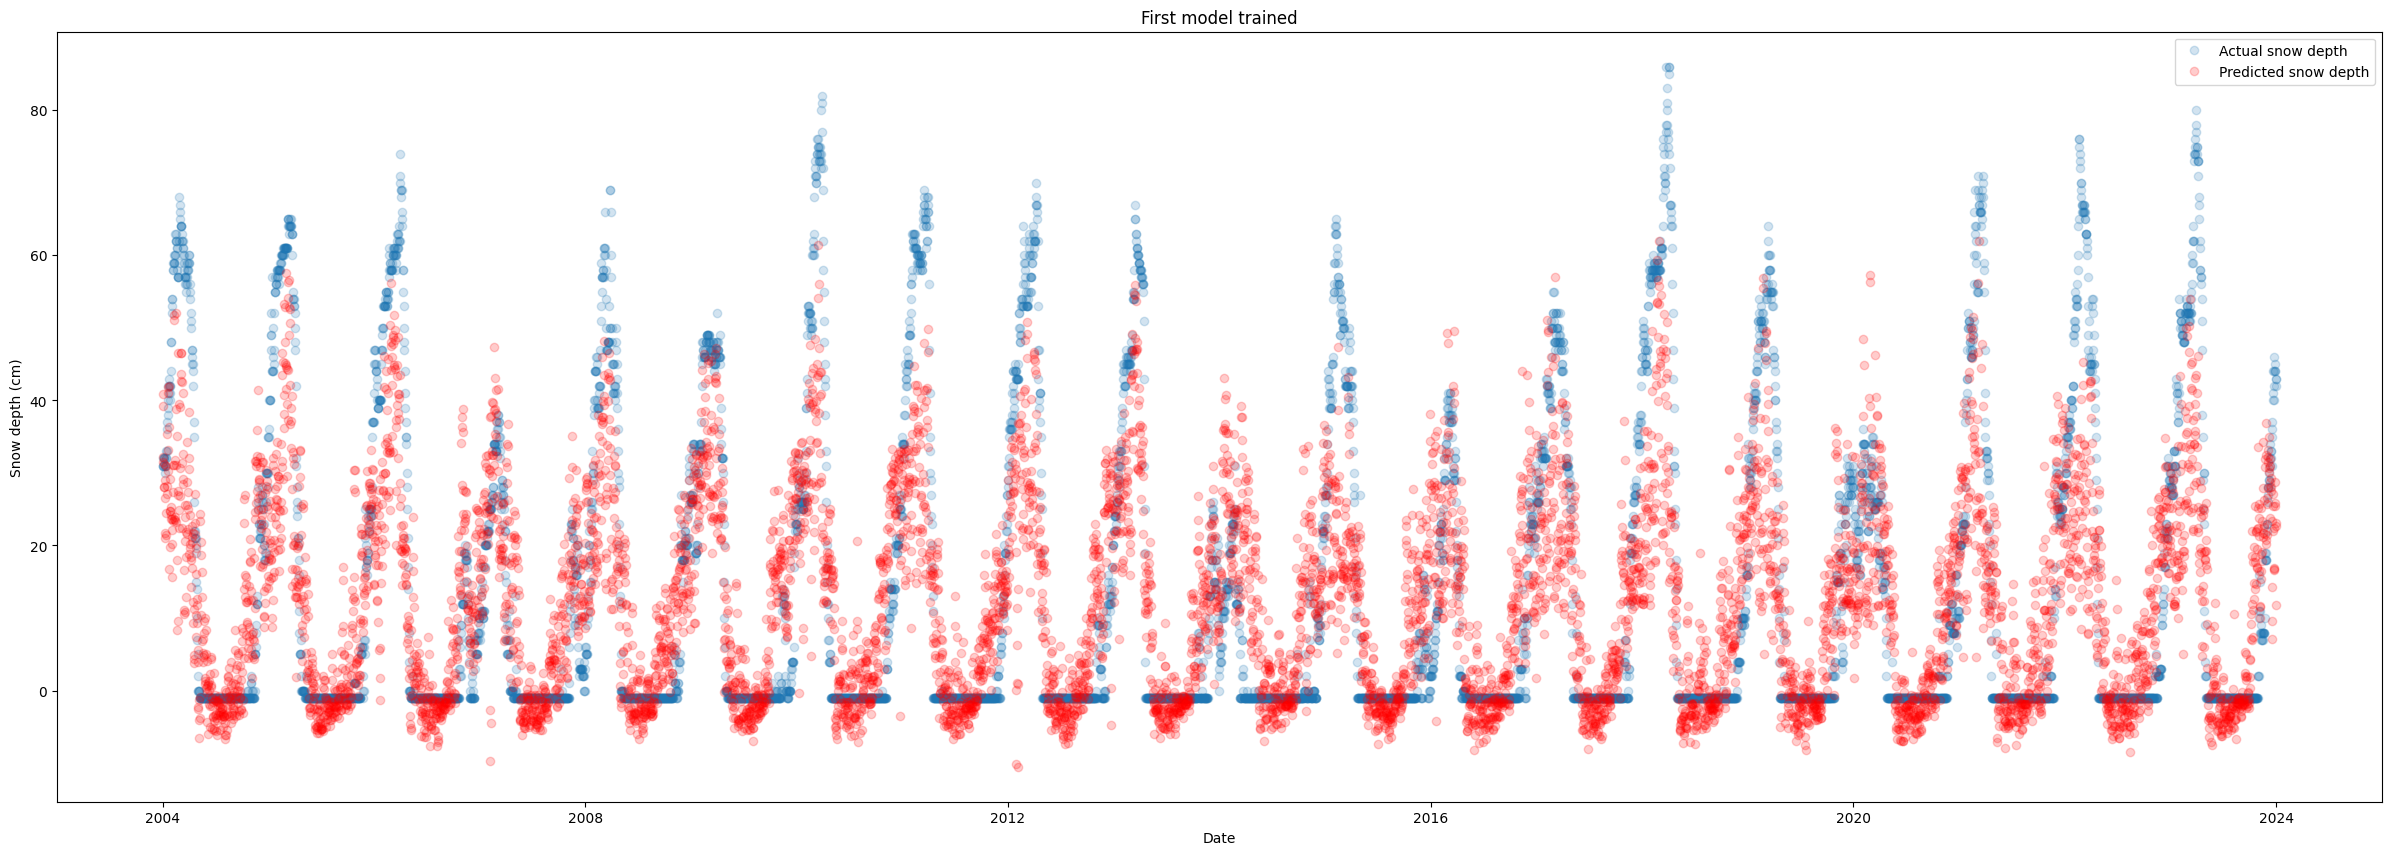

In [218]:
fig, ax = plt.subplots(figsize=(30,10))
 
%matplotlib inline
ax.plot(test_df['Date'], y_test, marker='o', ls='', alpha=0.2, label='Actual snow depth')
ax.plot(test_df['Date'], y_predicted_test3d, marker='o', ls='', c='red', alpha=0.2, label='Predicted snow depth')
 
ax.set(title='First model trained',xlabel='Date', ylabel='Snow depth (cm)')
ax.legend()
plt.show()

# 4th degree model against real values

In [219]:
# fig, ax = plt.subplots(figsize=(30,10))
 
# %matplotlib inline
# ax.plot(test_df['Date'], y_test, marker='o', ls='', alpha=0.2, label='Actual snow depth')
# ax.plot(test_df['Date'], y_predicted_test4d, marker='o', ls='', c='red', alpha=0.2, label='Predicted snow depth')
 
# ax.set(title='First model trained',xlabel='Date', ylabel='Snow depth (cm)')
# ax.legend()
# plt.show()

### 3. Save models

In [220]:
import save_print_load_as_binary as slb


slb.save_to_binary_file(model_3d,"C:\\Code\\Miniproject 2\\scripts\\presentation\\3dmodel.pkl" )


### 4. Predict

In [258]:
X_poly_levi = poly.fit_transform(future_levi_X)
levi_predicted = model_3d.predict(X_poly_levi)

X_poly_ruka = poly.fit_transform(future_ruka_X)
ruka_predicted = model_3d.predict(X_poly_ruka)

X_poly_koli = poly.fit_transform(future_koli_X)
koli_predicted = model_3d.predict(X_poly_koli)

X_poly_tahko = poly.fit_transform(future_tahko_X)
tahko_predicted = model_3d.predict(X_poly_tahko)

X_poly_messila = poly.fit_transform(future_messila_X)
messila_predicted = model_3d.predict(X_poly_messila)


In [263]:
levi_future_df = pd.DataFrame(levi_predicted)
levi_future_df['Date'] = future_levi['Date']
levi_future_df.to_csv("C:\\Code\\Miniproject 2\\predicted_data\\levi_future.csv", index=False)

ruka_future_df = pd.DataFrame(ruka_predicted)
ruka_future_df['Date'] = future_ruka['Date']
ruka_future_df.to_csv("C:\\Code\\Miniproject 2\\predicted_data\\ruka_future.csv", index=False)

koli_future_df = pd.DataFrame(koli_predicted)
koli_future_df['Date'] = future_koli['Date']
koli_future_df.to_csv("C:\\Code\\Miniproject 2\\predicted_data\\koli_future.csv", index=False)

tahko_future_df = pd.DataFrame(tahko_predicted)
tahko_future_df['Date'] = future_tahko['Date']
tahko_future_df.to_csv("C:\\Code\\Miniproject 2\\predicted_data\\tahko_future.csv", index=False)

messila_future_df = pd.DataFrame(messila_predicted)
messila_future_df['Date'] = future_messila['Date']
messila_future_df.to_csv("C:\\Code\\Miniproject 2\\predicted_data\\messila_future.csv", index=False)


### 5. Estimate accuray

In [47]:
import statsmodels.api as sm
 
# Add a constant column to the features (for intercept)
#X = sm.add_constant(X)
 
# Fit the multiple linear regression model
model = sm.OLS(y_train, X_train).fit()
 
# Print the summary of the regression model which includes p-values
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:       Snow depth_float   R-squared (uncentered):                   0.607
Model:                            OLS   Adj. R-squared (uncentered):              0.607
Method:                 Least Squares   F-statistic:                              9043.
Date:                Thu, 14 Mar 2024   Prob (F-statistic):                        0.00
Time:                        10:55:28   Log-Likelihood:                     -1.2687e+05
No. Observations:               29224   AIC:                                  2.538e+05
Df Residuals:                   29219   BIC:                                  2.538e+05
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

### 6. Repeat

# Visualizations